In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [2]:
# Interaction type lookup
import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
# print(interaction_dictionary)

In [6]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [7]:
#TO FIT STRAIGHT LINES

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def fitting(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    particleType = np.array([])
    
    for i in idx:
        pdg = events.mc_pdg[i]
        particleType = np.append(particleType, pdg)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
                plt.show()
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    return gradients, intercepts, resis, particleType

In [62]:
def hits(event_number):
    """Needs to return number of hits divided by the 
    length of the particle track/shower, and the particle type"""
    
    # Accessing a specific event.
    idx = np.where(events.event_number == event_number)[0]
    
    particleType = np.array([])
    allHits = np.array([])
    
    # Looping through each particle from the event
    for i in idx:
        
        # The position coordinates for the particle
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        if x.size <= 30:
            continue
            
        else:
            
            # The number of hits
            hit = len(x)
        
            # Finding the length
            xmin, xmax = x[0], x[-1]
            zmin, zmax = z[0], z[-1]
        
            length = np.sqrt((xmax - xmin)**2 + (zmax - zmin)**2)
            
            if length == 0:
                continue
                
            else:
                result = hit / length
                allHits = np.append(allHits, result)
                
                # Finding the particle type
                pdg = events.mc_pdg[i]
                particleType = np.append(particleType, pdg)
                
            
            # Plotting each particle
            plt.scatter(x, z, s = 50, label=f"{result}")
            plt.scatter(xmin, zmin, c='red', s=10)
            plt.scatter(xmax, zmax, c='red', s=10)
            plt.legend()
            plt.show()

        
    return allHits, particleType

In [31]:
hits(3)

(array([0.96031539, 1.92507112]), array([   0., -211.]))

In [53]:
random_numbers = np.random.randint(0, max(events.event_number), 100)

In [54]:
h = []
p = []
for i in random_numbers:
    h, p = np.append(h, hits(i)[0]), np.append(p, hits(i)

In [55]:
h.shape, p.shape

((254,), (254,))

In [56]:
df = pd.DataFrame({"hits": h, "particle": p})

In [57]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [58]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['hits'].values
showers = fshowers['hits'].values

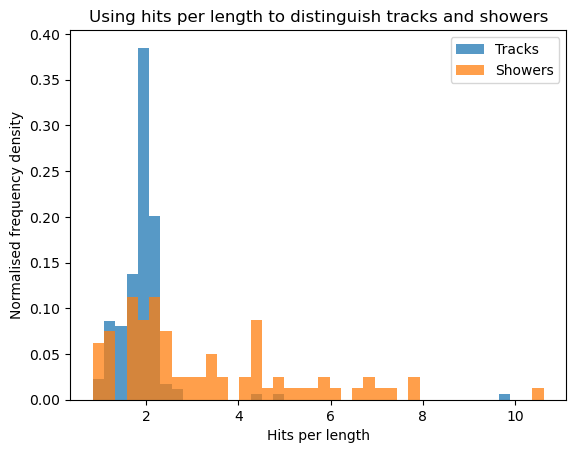

In [59]:
n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using hits per length to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Hits per length")

plt.legend()
plt.show()

In [60]:
random_numbers

array([1287, 5254, 3929, 6472, 6367, 1160, 4736, 3106, 6661, 8489, 3784,
       7212, 1969, 2673, 3220, 2555, 3228, 3105, 8473, 6664, 2585, 1639,
       2097,  909, 6685, 6878, 8348, 8875, 3768, 4135, 8867, 3582, 5758,
       1371, 5928, 7985, 3720, 6515,  779, 7806, 4583, 7957, 6360, 4482,
       3091, 7674, 1527, 5139, 8470, 5045, 8381, 3099, 4458, 2222,   19,
       5415, 5897, 7715, 4277, 9183, 3865,  385, 6371, 6397, 4381, 1469,
       4073, 6226, 4097, 8439, 7375, 2784, 8587, 3674, 1320, 3226, 3378,
       6188,  558, 7094, 7430, 8195, 6910, 9022,  344, 8730, 4036, 3070,
       4287, 3258, 6614, 3048, 3561, 7379, 4620, 4099, 8160,  504, 8982,
       5801])

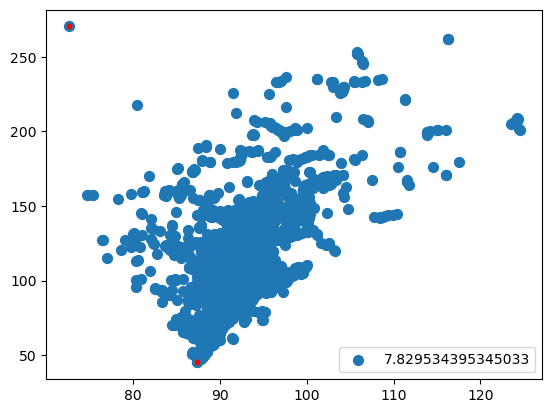

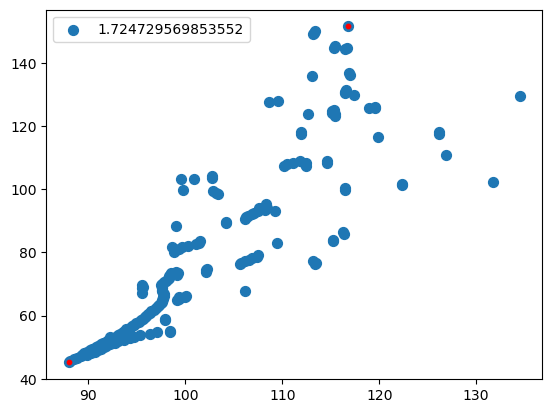

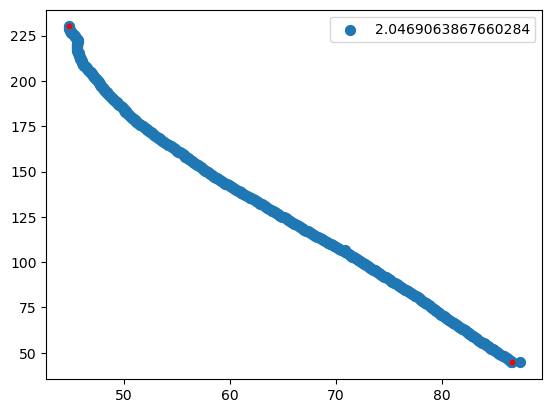

(array([7.8295344 , 1.72472957, 2.04690639]), array([11., 22., 13.]))

In [68]:
hits(1160)

In [8]:
def hits2(event_number):
    """Needs to return number of hits divided by the 
    length of the particle track/shower, and the particle type"""
    
    # Accessing a specific event.
    m, c, _, _ = fitting(event_number, False)
    idx = np.where(events.event_number == event_number)[0]
    
    particleType = np.array([])
    allHits = np.array([])
    
    # Looping through each particle from the event
    for i in idx:
        
        # The position coordinates for the particle
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        if x.size <= 30:
            continue
            
        else:
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
            
            # The number of hits
            hit = len(l)
            
            lmin, lmax = np.min(l), np.max(l)
        
            length = lmax - lmin
            
            if length == 0:
                continue
                
            else:
                result = hit / length
                allHits = np.append(allHits, result)
                
                # Finding the particle type
                pdg = events.mc_pdg[i]
                particleType = np.append(particleType, pdg)
                
            
                # Plotting each particle
#                 plt.scatter(x,z)
#                 plt.show()
                
#                 plt.scatter(l, t, s = 50, label=f"{result}")
#                 plt.legend()
#                 plt.show()

        
    return allHits, particleType

In [9]:
random_numbers = np.random.randint(0, max(events.event_number), 1000)

In [10]:
h = []
p = []
for i in random_numbers:
    h, p = np.append(h, hits2(i)[0]), np.append(p, hits2(i)[1])

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
h.shape, p.shape

((4072,), (4072,))

In [12]:
df = pd.DataFrame({"hits": h, "particle": p})

In [13]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [14]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['hits'].values
showers = fshowers['hits'].values

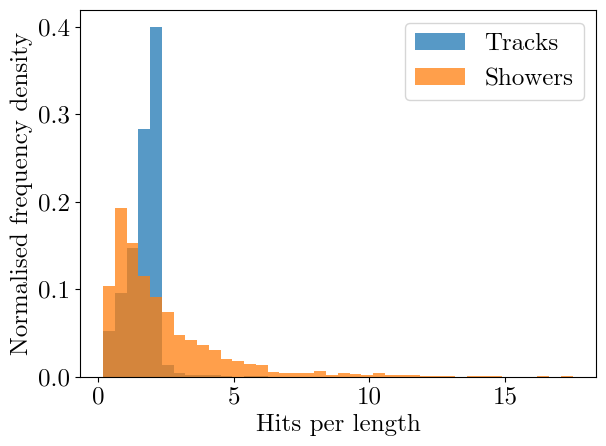

In [26]:
n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
# plt.title("Using hits per length to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Hits per length")

plt.legend()
plt.tight_layout()
plt.savefig('hits.png', dpi = 500)
plt.show()

In [24]:
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 18
random_numbers

array([3993, 1533, 9178, 9110,  588, 3423, 2526, 5719, 5462, 8606, 3629,
       4048, 4880, 1014, 4976, 5083, 5948, 5988, 4867, 2077, 1213, 4839,
       6323, 5239, 2714, 7506, 7596, 1830, 5832, 8952, 6159, 7066, 4038,
       2811, 6361, 6135, 7780, 6126, 7275,  281, 5804, 8259,  354, 6629,
       4548, 1007, 7849,  896, 1392, 9045, 7828, 5010, 4283, 7953, 2699,
       5366, 7750, 3947, 2335,  272, 3613, 4775, 7173,  447, 3358, 4174,
       1440, 8265, 2394, 7143, 7983, 1239, 5843, 5838, 8687, 1146, 5403,
        764, 4281, 7980, 2477, 7438, 3018, 4826,  887, 7523, 4363, 3350,
        380, 2765, 6567, 3065, 4049, 5550, 2804, 5629, 9061, 5537, 1262,
       6329, 1188, 8428, 3594, 8808, 2634, 9076, 5877, 3580, 9168, 4085,
       2140, 8234, 4476, 1389,   62, 9187, 3095, 3629, 8989, 4606, 1051,
       4212,  913, 4865, 4622, 9126, 1707, 4709, 9045, 2211, 6782, 1912,
       2996,  523, 4864, 7170, 1971,  110, 8145, 7826, 6798, 3502, 5372,
       3738, 6953, 7824, 7206, 1093, 1169,  567, 92

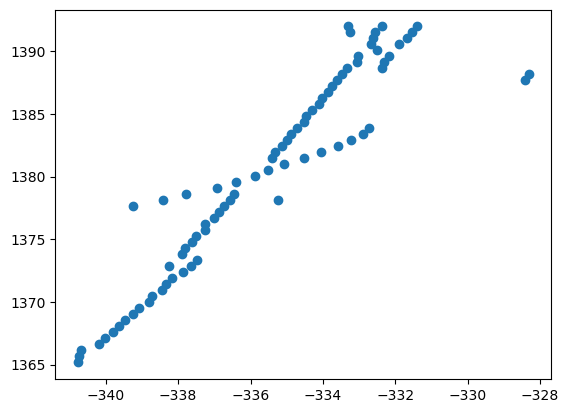

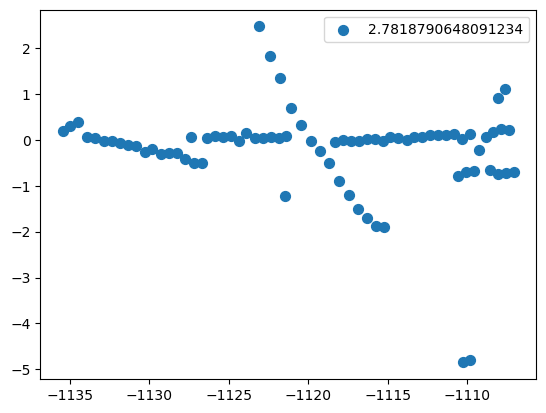

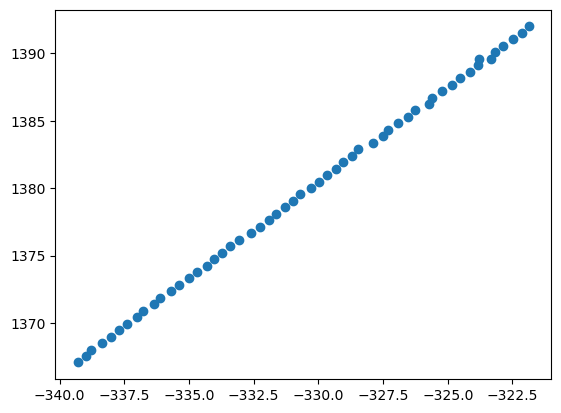

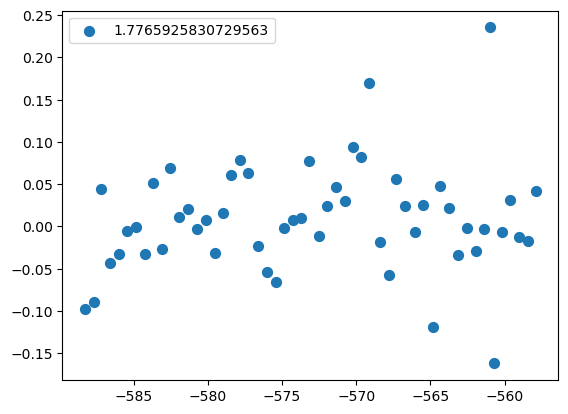

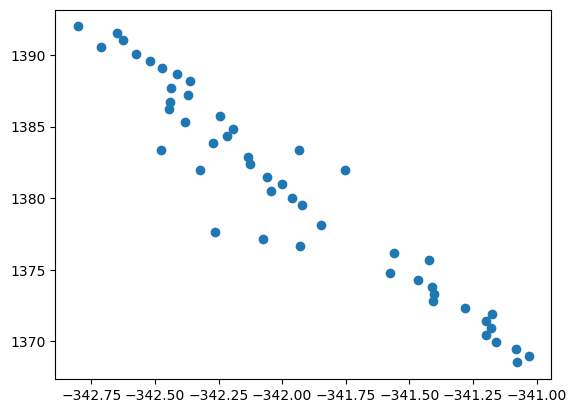

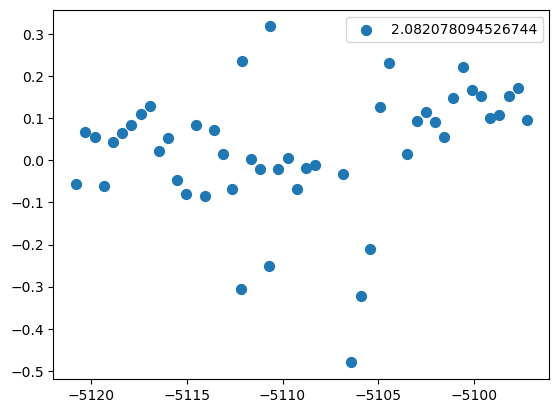

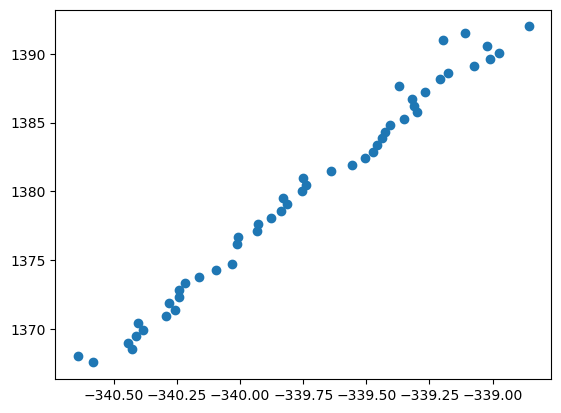

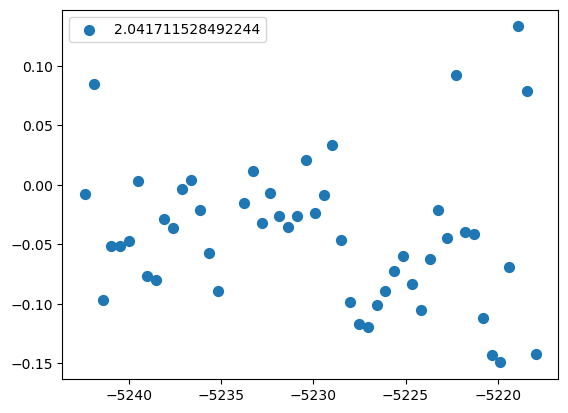

(array([2.78187906, 1.77659258, 2.08207809, 2.04171153]),
 array([-211.,  211.,   13.,   22.]))

In [144]:
hits2(5884)